Find best Parameter of Techical Indicator for 3 assets BTC,Gold,S&P500 and use eqaul weight compare optimize weight of port optimization 

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
from scipy.optimize import minimize
from plotly.subplots import make_subplots
from scipy.optimize import minimize
import plotly.express as px
import plotly.graph_objs as go

In [2]:
def moving_average_strategy(data, short_window, long_window, strategy_type='both'):
    signals = pd.DataFrame(index=data.index)
    # signals['price'] = data['Close']
    # signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    # signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1).mean()
    signals['price'] = data
    signals['short_mavg'] = data.rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data.rolling(window=long_window, min_periods=1).mean()
    signals['signal'] = 0.0
    
    # Generate signals based on the strategy type
    if strategy_type == 'long':
        signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(
            signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:], 1.0, 0.0
        )
    elif strategy_type == 'short':
        signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(
            signals['short_mavg'].iloc[short_window:] < signals['long_mavg'].iloc[short_window:], -1.0, 0.0
        )
    else:  # Both long and short signals
        signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(
            signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:], 1.0,
            np.where(signals['short_mavg'].iloc[short_window:] < signals['long_mavg'].iloc[short_window:], -1.0, 0.0)
        )
    signals['signal']=signals['signal'].shift(1)
    signals['positions'] = signals['signal'].diff()
    return signals

def moving_average_strategy_with_tp_sl(data, short_window, long_window, tp_pct, sl_pct, strategy_type='both'):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1).mean()
    signals['signal'] = 0.0
    
    # Generate initial signals based on the moving average crossover
    if strategy_type == 'long':
        signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(
            signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:], 1.0, 0.0
        )
    elif strategy_type == 'short':
        signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(
            signals['short_mavg'].iloc[short_window:] < signals['long_mavg'].iloc[short_window:], -1.0, 0.0
        )
    else:  # Both long and short signals
        signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(
            signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:], 1.0,
            np.where(signals['short_mavg'].iloc[short_window:] < signals['long_mavg'].iloc[short_window:], -1.0, 0.0)
        )
    
    # Initialize columns for tracking TP and SL
    signals['entry_price'] = np.nan
    signals['tp_price'] = np.nan
    signals['sl_price'] = np.nan
    
    # Set entry prices, TP, and SL levels based on signals
    for i in range(1, len(signals)):
        if signals['signal'].iloc[i] == 1.0 and signals['signal'].iloc[i-1] != 1.0:  # Long signal
            signals.at[signals.index[i], 'entry_price'] = signals['price'].iloc[i]
            signals.at[signals.index[i], 'tp_price'] = signals['price'].iloc[i] * (1 + tp_pct)
            signals.at[signals.index[i], 'sl_price'] = signals['price'].iloc[i] * (1 - sl_pct)
        elif signals['signal'].iloc[i] == -1.0 and signals['signal'].iloc[i-1] != -1.0:  # Short signal
            signals.at[signals.index[i], 'entry_price'] = signals['price'].iloc[i]
            signals.at[signals.index[i], 'tp_price'] = signals['price'].iloc[i] * (1 - tp_pct)
            signals.at[signals.index[i], 'sl_price'] = signals['price'].iloc[i] * (1 + sl_pct)

        # Apply TP and SL
        if signals['signal'].iloc[i] == 1.0:  # Long position
            if signals['price'].iloc[i] >= signals['tp_price'].iloc[i-1]:  # Take Profit
                signals.at[signals.index[i], 'signal'] = 0.0
            elif signals['price'].iloc[i] <= signals['sl_price'].iloc[i-1]:  # Stop Loss
                signals.at[signals.index[i], 'signal'] = 0.0
        elif signals['signal'].iloc[i] == -1.0:  # Short position
            if signals['price'].iloc[i] <= signals['tp_price'].iloc[i-1]:  # Take Profit
                signals.at[signals.index[i], 'signal'] = 0.0
            elif signals['price'].iloc[i] >= signals['sl_price'].iloc[i-1]:  # Stop Loss
                signals.at[signals.index[i], 'signal'] = 0.0
    
    # Track position changes
    signals['signal']=signals['signal'].shift(1)
    signals['positions'] = signals['signal'].diff()
    
    return signals

# Calculate Bollinger Bands and generate signals
def bollinger_bands_strategy(data, window, num_std_dev):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    signals['middle_band'] = data['Close'].rolling(window=window).mean()
    signals['std_dev'] = data['Close'].rolling(window=window).std()
    signals['upper_band'] = signals['middle_band'] + (signals['std_dev'] * num_std_dev)
    signals['lower_band'] = signals['middle_band'] - (signals['std_dev'] * num_std_dev)
    
    signals['signal'] = 0.0
    signals.iloc[window:, signals.columns.get_loc('signal')] = np.where(
        data['Close'].iloc[window:] < signals['lower_band'].iloc[window:], 1.0, 
        np.where(data['Close'].iloc[window:] > signals['upper_band'].iloc[window:], -1.0, 0.0)
    )
    signals['signal']=signals['signal'].shift(1)
    signals['positions'] = signals['signal'].diff()
    return signals

def bollinger_bands_strategy_with_exit(data, window, num_std_dev):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    signals['middle_band'] = data['Close'].rolling(window=window).mean()
    signals['std_dev'] = data['Close'].rolling(window=window).std()
    signals['upper_band'] = signals['middle_band'] + (signals['std_dev'] * num_std_dev)
    signals['lower_band'] = signals['middle_band'] - (signals['std_dev'] * num_std_dev)
    
    signals['signal'] = 0.0
    signals['entry_price'] = np.nan
    signals['exit_reason'] = ''
    position = 0
    entry_price = 0

    lower_band = signals['lower_band'].values
    upper_band = signals['upper_band'].values
    middle_band = signals['middle_band'].values
    close_price = data['Close'].values

    for i in range(window, len(signals)):
        if position == 0:
            if close_price[i] < lower_band[i]:
                signals.iloc[i, signals.columns.get_loc('signal')] = 1.0  # Buy signal
                position = 1
                entry_price = close_price[i]
                signals.iloc[i, signals.columns.get_loc('entry_price')] = entry_price
            elif close_price[i] > upper_band[i]:
                signals.iloc[i, signals.columns.get_loc('signal')] = -1.0  # Sell signal
                position = -1
                entry_price = close_price[i]
                signals.iloc[i, signals.columns.get_loc('entry_price')] = entry_price
        elif position == 1:
            signals.iloc[i, signals.columns.get_loc('signal')] = 1.0  # Maintain long signal
            if close_price[i] >= middle_band[i] or middle_band[i] < entry_price:
                signals.iloc[i, signals.columns.get_loc('signal')] = 0.0  # Close long position
                signals.iloc[i, signals.columns.get_loc('exit_reason')] = 'Exit Long'
                position = 0
        elif position == -1:
            signals.iloc[i, signals.columns.get_loc('signal')] = -1.0  # Maintain short signal
            if close_price[i] <= middle_band[i] or middle_band[i] > entry_price:
                signals.iloc[i, signals.columns.get_loc('signal')] = 0.0  # Close short position
                signals.iloc[i, signals.columns.get_loc('exit_reason')] = 'Exit Short'
                position = 0

    # Correctly update positions based on signal change
    signals['signal']=signals['signal'].shift(1)
    signals['positions'] = signals['signal'].diff().fillna(0)
    
    return signals

def bollinger_bands_strategy_with_tp_sl(data, window, num_std_dev, tp_scale, sl_scale):
    """
    Bollinger Bands strategy with Take Profit (TP) and Stop Loss (SL) levels.

    Parameters:
        data (pd.Series): Series of asset prices (e.g., closing prices).
        window (int): Rolling window size for Bollinger Bands calculation.
        num_std_dev (float): Number of standard deviations for upper and lower bands.
        tp_scale (float): Multiplier for Take Profit levels.
        sl_scale (float): Multiplier for Stop Loss levels.

    Returns:
        pd.DataFrame: DataFrame containing signals, TP/SL levels, and other relevant columns.
    """
    epsilon = 1e-8  # Small value to avoid divide-by-zero errors

    signals = pd.DataFrame(index=data.index)
    signals['price'] = data
    signals['middle_band'] = data.rolling(window=window).mean()
    signals['std_dev'] = data.rolling(window=window).std() + epsilon  # Add epsilon to avoid zero std_dev
    signals['upper_band'] = signals['middle_band'] + (signals['std_dev'] * num_std_dev)
    signals['lower_band'] = signals['middle_band'] - (signals['std_dev'] * num_std_dev)

    signals['signal'] = 0.0
    signals['tp_price'] = np.nan
    signals['sl_price'] = np.nan
    signals['exit_reason'] = ''
    position = 0
    entry_price = 0

    for d in signals.index[window:]:
        current_price = data.loc[d]

        if position == 0:
            # Enter long position
            if current_price < signals.loc[d, 'lower_band']:
                signals.loc[d, 'signal'] = 1.0
                position = 1
                entry_price = current_price
                tp = entry_price + (tp_scale * signals.loc[d, 'std_dev'])
                sl = entry_price - (sl_scale * signals.loc[d, 'std_dev'])
                signals.loc[d, 'tp_price'] = tp
                signals.loc[d, 'sl_price'] = sl

            # Enter short position
            elif current_price > signals.loc[d, 'upper_band']:
                signals.loc[d, 'signal'] = -1.0
                position = -1
                entry_price = current_price
                tp = entry_price - (tp_scale * signals.loc[d, 'std_dev'])
                sl = entry_price + (sl_scale * signals.loc[d, 'std_dev'])
                signals.loc[d, 'tp_price'] = tp
                signals.loc[d, 'sl_price'] = sl

        elif position == 1:  # Long position
            signals.loc[d, 'signal'] = 1.0
            signals.loc[d, 'tp_price'] = tp
            signals.loc[d, 'sl_price'] = sl

            # Check TP or SL hit
            if current_price >= tp or current_price <= sl:
                signals.loc[d, 'signal'] = 0.0
                signals.loc[d, 'exit_reason'] = 'TP Hit' if current_price >= tp else 'SL Hit'
                position = 0

        elif position == -1:  # Short position
            signals.loc[d, 'signal'] = -1.0
            signals.loc[d, 'tp_price'] = tp
            signals.loc[d, 'sl_price'] = sl

            # Check TP or SL hit
            if current_price <= tp or current_price >= sl:
                signals.loc[d, 'signal'] = 0.0
                signals.loc[d, 'exit_reason'] = 'TP Hit' if current_price <= tp else 'SL Hit'
                position = 0

    # Shift signals to avoid lookahead bias
    signals['signal'] = signals['signal'].shift(1)
    signals['positions'] = signals['signal'].diff().fillna(0)

    return signals


def calculate_rsi(data, window=14):
    """
    Calculate the Relative Strength Index (RSI).

    Parameters:
        data (pd.Series): Price data.
        window (int): Lookback window for RSI calculation.

    Returns:
        pd.Series: RSI values.
    """
    delta = data.diff()

    # Calculate rolling gains and losses
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    # Replace zero losses with NaN to avoid division by zero
    loss = loss.replace(0, np.nan)

    # Calculate relative strength (RS) and RSI
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # Replace NaN RSI with 50 (neutral level)
    rsi = rsi.fillna(50)

    return rsi


def rsi_strategy(data, rsi_window=14, overbought=70, oversold=30, close_on_50=True):
    print("1",rsi_window,overbought,oversold)
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data
    
    signals['rsi'] = calculate_rsi(data, window=rsi_window)
    signals['signal'] = 0.0
    print("2")
    # Generate buy signals when RSI is below the oversold threshold
    signals.loc[signals['rsi'] < oversold, 'signal'] = 1.0
    
    # Generate sell signals when RSI is above the overbought threshold
    signals.loc[signals['rsi'] > overbought, 'signal'] = -1.0
    print("3")
    # Close positions when RSI crosses 50
    if close_on_50:
        signals.loc[(signals['rsi'] >= 50) & (signals['rsi'].shift(1) < 50) & (signals['signal'] == 1.0), 'signal'] = 0.0
        signals.loc[(signals['rsi'] <= 50) & (signals['rsi'].shift(1) > 50) & (signals['signal'] == -1.0), 'signal'] = 0.0

    signals['signal']=signals['signal'].shift(1)
    signals['positions'] = signals['signal'].diff()
    return signals

def rsi_strategy_with_tp_sl(data, rsi_window=14, overbought=70, oversold=30, close_on_50=True, tp_pct=0.02, sl_pct=0.01):
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data
    signals['rsi'] = calculate_rsi(data, window=rsi_window)
    signals['signal'] = 0.0
    signals['tp_price'] = 0.0
    signals['sl_price'] = 0.0
    signals['holding_duration'] = 0  # Initialize the holding duration column
    position_open = False
    position_open_date = None
    oversold_crossed = False
    overbought_crossed = False
    
    for i in range(1, len(signals)):
        if position_open:
            # Check for take profit
            if signals.loc[signals.index[i], 'price'] >= signals.loc[signals.index[i-1], 'tp_price']:
                signals.loc[signals.index[i], 'signal'] = -1.0  # Sell signal
                position_open = False
                signals.loc[signals.index[i], 'holding_duration'] = (signals.index[i] - position_open_date).days
            # Check for stop loss
            elif signals.loc[signals.index[i], 'price'] <= signals.loc[signals.index[i-1], 'sl_price']:
                signals.loc[signals.index[i], 'signal'] = -1.0  # Sell signal
                position_open = False
                signals.loc[signals.index[i], 'holding_duration'] = (signals.index[i] - position_open_date).days
            else:
                continue
        
        # Track if RSI crosses oversold
        if signals.loc[signals.index[i], 'rsi'] < oversold:
            oversold_crossed = True
        
        # Track if RSI crosses overbought
        if signals.loc[signals.index[i], 'rsi'] > overbought:
            overbought_crossed = True
        
        # Generate buy signals when RSI crosses back above oversold threshold
        if oversold_crossed and signals.loc[signals.index[i], 'rsi'] > oversold:
            signals.loc[signals.index[i], 'signal'] = 1.0
            position_open = True
            position_open_date = signals.index[i]  # Record the date when the position was opened
            oversold_crossed = False
            # Set take profit and stop loss prices
            entry_price = signals.loc[signals.index[i], 'price']
            signals.loc[signals.index[i], 'tp_price'] = entry_price * (1 + tp_pct)
            signals.loc[signals.index[i], 'sl_price'] = entry_price * (1 - sl_pct)
        
        # Generate sell signals when RSI crosses back below overbought threshold
        if overbought_crossed and signals.loc[signals.index[i], 'rsi'] < overbought:
            signals.loc[signals.index[i], 'signal'] = -1.0
            position_open = True
            position_open_date = signals.index[i]  # Record the date when the position was opened
            overbought_crossed = False
            # Set take profit and stop loss prices
            entry_price = signals.loc[signals.index[i], 'price']
            signals.loc[signals.index[i], 'tp_price'] = entry_price * (1 - tp_pct)
            signals.loc[signals.index[i], 'sl_price'] = entry_price * (1 + sl_pct)

        # Close positions when RSI crosses 50 (if enabled)
        if close_on_50:
            if (signals.loc[signals.index[i], 'rsi'] >= 50) and (signals.loc[signals.index[i-1], 'rsi'] < 50) and (signals.loc[signals.index[i-1], 'signal'] == 1.0):
                signals.loc[signals.index[i], 'signal'] = 0.0
                position_open = False
                signals.loc[signals.index[i], 'holding_duration'] = (signals.index[i] - position_open_date).days
            elif (signals.loc[signals.index[i], 'rsi'] <= 50) and (signals.loc[signals.index[i-1], 'rsi'] > 50) and (signals.loc[signals.index[i-1], 'signal'] == -1.0):
                signals.loc[signals.index[i], 'signal'] = 0.0
                position_open = False
                signals.loc[signals.index[i], 'holding_duration'] = (signals.index[i] - position_open_date).days
    signals['signal']=signals['signal'].shift(1)
    signals['positions'] = signals['signal'].diff()
    return signals


def backtest_strategy(signals, leverage, initial_capital):
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions['asset_price'] = signals['signal']
    portfolio = positions.multiply(signals['price'], axis=0)
    pos_diff = positions.diff()


    portfolio['holdings'] = (positions.multiply(signals['price'], axis=0)).sum(axis=1) * leverage
    portfolio['cash'] = initial_capital - (pos_diff.multiply(signals['price'], axis=0)).sum(axis=1).cumsum() * leverage
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()
    portfolio['signal'] = signals['signal']
    portfolio['positions'] = signals['positions']

    # Adjust portfolio to ensure 'total' is not less than 0
    for i in range(1, len(portfolio)):
        if portfolio['total'].iloc[i] < 0:
            portfolio.iloc[i:, portfolio.columns.get_loc('total')] = 0
            portfolio.iloc[i:, portfolio.columns.get_loc('cash')] = 0
            portfolio.iloc[i:, portfolio.columns.get_loc('holdings')] = 0
            break

    return portfolio

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

def minimize_variance(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def optimize_portfolio_min_variance(mean_returns, cov_matrix, required_return, weight_limit,threshold=0.01):
    num_assets = len(mean_returns)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - required_return})
    bounds = tuple((0, weight_limit) for _ in range(num_assets))  # Set upper bound to weight_limit for each asset
    result = minimize(minimize_variance, num_assets * [1. / num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        optimal_weights = result.x
        variance = minimize_variance(optimal_weights, cov_matrix)
        
        # Remove small weights
        adjusted_weights = np.where(optimal_weights < threshold, 0, optimal_weights)
        
        # Normalize the remaining weights to ensure they sum to one
        adjusted_weights /= np.sum(adjusted_weights)
        
        return adjusted_weights, variance
    else:
        return None,None

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate, weight_limit, threshold=0.01):
    num_assets = len(mean_returns)
    
    def sharpe_ratio(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility  # Negative Sharpe ratio to maximize
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, weight_limit) for _ in range(num_assets))
    result = minimize(sharpe_ratio, num_assets * [1. / num_assets,], method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        optimal_weights = result.x
        
        # Remove small weights
        adjusted_weights = np.where(optimal_weights < threshold, 0, optimal_weights)
        
        # Normalize the remaining weights to ensure they sum to one
        adjusted_weights /= np.sum(adjusted_weights)
        
        max_sharpe_ratio = -result.fun  # Since we minimized the negative Sharpe ratio
        return adjusted_weights, max_sharpe_ratio
    else:
        return None, None

risk_free_rate = 0.02/252/24  # Example risk-free rate per period

# Calculate the Sharpe ratio for each strategy
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    annualized_return = excess_returns.mean() * 5727  # Assuming 252 trading days in a year
    annualized_volatility = excess_returns.std() * np.sqrt(5727)
    sharpe_ratio = annualized_return / annualized_volatility
    return sharpe_ratio

def calculate_performance_metrics(cumulative_returns, risk_free_rate,interval_input='1h'):
    # Max Drawdown
    running_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / running_max - 1
    max_drawdown = drawdown.min()
    
    # Reconstruct daily returns from cumulative returns
    hourly_returns = cumulative_returns.pct_change().fillna(0)
    
    # Sharpe Ratio
    if interval_input=='1h':
        m=24
    elif interval_input=='1d':
        m=1
    excess_returns = hourly_returns - risk_free_rate  # Adjusting the risk-free rate to daily
    annualized_return = excess_returns.mean() * m*252  # Assuming 252 trading days in a year
    annualized_volatility = excess_returns.std() * np.sqrt(m*252)
    sharpe_ratio = annualized_return / annualized_volatility
    
    return annualized_return,max_drawdown,sharpe_ratio

def ma_backtest(data):
    short_windows = list(range(2, 100,2))
    long_windows = list(range(20, 800,10))
    results = pd.DataFrame(index=short_windows, columns=long_windows)
    returns_list = []
    # Loop over the short and long windows
    for short_window in short_windows:
        for long_window in long_windows:
            if short_window < long_window:
                # Generate signals
                signals = moving_average_strategy(data, short_window, long_window)
                # Backtest strategy
                portfolio = backtest_strategy(signals, leverage, initial_capital)
                # Calculate cumulative return
                cumulative_return = portfolio['total'].iloc[-1] / initial_capital - 1
                # Store the result
                results.loc[short_window, long_window] = cumulative_return
                strategy_name = f'S{short_window}_L{long_window}'
                returns_list.append(portfolio['returns'].rename(strategy_name))

    # Convert results to numeric values for plotting
    results = results.apply(pd.to_numeric)

    strategy_ma = pd.concat(returns_list, axis=1)
    return strategy_ma

def bb_backtest(data):
    window_ranges = list(range(10, 210, 20))
    num_std_dev_ranges = list(range(5,30))

    results = pd.DataFrame(index=window_ranges, columns=[num_std_dev/10 for num_std_dev in num_std_dev_ranges])
    returns_list = []

    # Loop over the window and standard deviation ranges
    for window in window_ranges:
        for num_std_dev in num_std_dev_ranges:
            # Generate signals
            signals = bollinger_bands_strategy_with_exit(data, window, num_std_dev/10)
            # Backtest strategy
            portfolio = backtest_strategy(signals, leverage, initial_capital)
            # Calculate cumulative return
            cumulative_return = portfolio['total'].iloc[-1] / initial_capital - 1
            # Store the result
            results.loc[window, num_std_dev/10] = cumulative_return
            strategy_name = f'Bollinger_W{window}_SD{num_std_dev/10}'
            returns_list.append(portfolio['returns'].rename(strategy_name))

    # Convert results to numeric values for plotting
    results = results.apply(pd.to_numeric)

    strategy_bb = pd.concat(returns_list, axis=1)

    return strategy_bb

def run_opt(strategy_df):

    # Optimize the portfolio for minimum variance given the required return and weight limit
    metric_result = optimize_max_sharpe(strategy_df)
    if metric_result['weights'] is not None:
        #print("Result",result)
        return metric_result['weights']
    else:
        return None

def forward_test(strategy_df,optimal_weights):
    opt_returns_ma = strategy_df.dot(optimal_weights)
    return opt_returns_ma


def all_forward(data_df,forward_df,results_df):
    #data_df=strategy_ma.iloc[i*monthly_period:(i+month_range)*monthly_period]
    optimal_weights_ma=run_opt(data_df)
    #print(optimal_weights_ma)
    if optimal_weights_ma is not None:
        #forward_df=strategy_ma.iloc[-forward_period:]
        optimal_weights_df = pd.DataFrame(optimal_weights_ma, index=data_df.columns, columns=['Weight'])
        optimal_weights_df = optimal_weights_df.reset_index()
        optimal_weights_df['date']=forward_df.index[0]
        optimal_weights_df=optimal_weights_df[optimal_weights_df['Weight']>0]
        opt_retrun_df=forward_test(forward_df,optimal_weights_ma)
        if len(results_df)>0:
            results_df=pd.concat([results_df,opt_retrun_df])
        else:
            results_df=opt_retrun_df.copy()
        return results_df,optimal_weights_df
    else:
        #print("result_df")
        #print(results_df.head())
        #print("No weight found")
        return results_df,None

def calculate_metrics(daily_returns, risk_free_rate=0.02, trading_days=252):
    """
    Calculate annual return, annualized volatility, and Sharpe ratio from daily returns.

    Parameters:
        daily_returns (pd.Series): A pandas Series of daily returns.
        risk_free_rate (float): The risk-free rate for Sharpe ratio calculation (default is 0.0).
        trading_days (int): The number of trading days in a year (default is 252).

    Returns:
        dict: A dictionary with annual return, annualized volatility, and Sharpe ratio.
    """
    # Annual Return
    cumulative_return = (1 + daily_returns).prod() - 1
    annual_return = (1 + cumulative_return) ** (trading_days / len(daily_returns)) - 1

    # Annualized Volatility
    annual_volatility = daily_returns.std() * np.sqrt(trading_days)

    # Sharpe Ratio
    daily_risk_free_rate = (1 + risk_free_rate) ** (1 / trading_days) - 1
    excess_daily_returns = daily_returns - daily_risk_free_rate
    sharpe_ratio = excess_daily_returns.mean() / daily_returns.std() * np.sqrt(trading_days)

    return {
        "annual_return": annual_return,
        "annual_volatility": annual_volatility,
        "sharpe_ratio": sharpe_ratio
    }

def optimize_min_volatility(returns_df, trading_days=252):
    """
    Optimize portfolio for minimum volatility.

    Parameters:
        returns_df (pd.DataFrame): Daily returns of assets in the portfolio.
        trading_days (int): Number of trading days in a year.

    Returns:
        dict: Optimal weights and portfolio metrics for minimum volatility.
    """
    mean_returns = returns_df.mean() * trading_days
    cov_matrix = returns_df.cov() * trading_days
    num_assets = len(mean_returns)

    # Objective function for minimum volatility
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds: weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Initial guess: equal weights
    initial_weights = num_assets * [1. / num_assets]

    # Optimization
    result = minimize(
        portfolio_volatility, initial_weights, method='SLSQP',
        bounds=bounds, constraints=constraints
    )

    # Calculate portfolio metrics
    weights = result.x
    portfolio_return = np.dot(returns_df,weights)

    return {
        "weights": weights,
        "Port": portfolio_return,
    }


def optimize_max_sharpe(returns_df,trading_days=252):
    """
    Optimize portfolio for maximum Sharpe ratio.

    Parameters:
        returns_df (pd.DataFrame): Daily returns of assets in the portfolio.
        risk_free_rate (float): Annual risk-free rate for Sharpe ratio calculation.
        trading_days (int): Number of trading days in a year.

    Returns:
        dict: Optimal weights and portfolio metrics for maximum Sharpe ratio.
    """
    mean_returns = returns_df.mean() * trading_days
    cov_matrix = returns_df.cov() * trading_days
    num_assets = len(mean_returns)

    # Objective function for negative Sharpe ratio
    def negative_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_vol

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds: weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Initial guess: equal weights
    initial_weights = num_assets * [1. / num_assets]

    # Optimization
    result = minimize(
        negative_sharpe_ratio, initial_weights, method='SLSQP',
        bounds=bounds, constraints=constraints
    )

    # Calculate portfolio metrics
    weights = result.x
    portfolio_return = np.dot(returns_df,weights)

    return {
        "weights": weights,
        "Port": portfolio_return,
    }




In [4]:
# Define the Forex pairs and Gold symbol
symbols = ['BTC-USD', 'GC=F','^GSPC','TLT']

# Download historical data
data = yf.download(symbols, start="2016-01-01")

[*********************100%***********************]  4 of 4 completed


In [5]:
df=data['Close']
df.columns=['BTC','Gold','SP500','Bond10y']

In [52]:
df

,BTC,Gold,SP500,Bond10y
Date,,,,
2016-01-01,434.334015,NaN,NaN,NaN
2016-01-02,433.437988,NaN,NaN,NaN
2016-01-03,430.010986,NaN,NaN,NaN
2016-01-04,433.091003,1075.099976,96.831284,2012.660034
2016-01-05,431.959991,1078.400024,96.440590,2016.709961
...,...,...,...,...
2024-12-23,94686.242188,2612.300049,87.500000,5974.069824
2024-12-24,98676.093750,2620.000000,87.870003,6040.040039
2024-12-25,99299.195312,NaN,NaN,NaN


<Axes: title={'center': 'Basic Weighted Portfolio'}, xlabel='Date'>

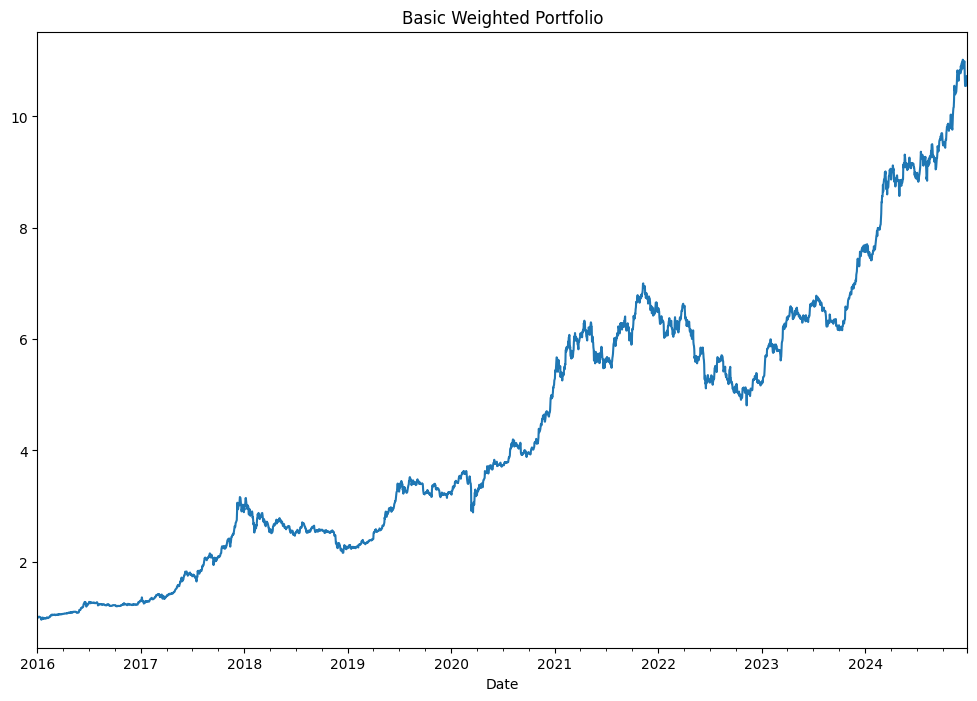

In [125]:
asset_eqw = [0.25,0.25,0.25,0.25]
basic_weight_pct=(df.pct_change(fill_method=None)*asset_eqw).sum(axis=1)
basic_weight_df=(1+basic_weight_pct).cumprod()
basic_weight_df.plot(figsize=(12,8),title='Basic Weighted Portfolio')

In [126]:
calculate_metrics(basic_weight_pct)

{'annual_return': np.float64(0.19907900666411482),
 'annual_volatility': np.float64(0.16102015658880417),
 'sharpe_ratio': np.float64(1.0855816910433884)}

In [111]:
signals.to_csv('sample_portfolio.csv')

Find return of each parameter of ma cross over short and long for 3 assets

In [8]:
# Parameters
leverage = 1
initial_capital = 10000.0

short_windows = list(range(2, 25, 1))
long_windows = list(range(5, 50, 2))

# Initialize an empty list to collect results
results_list = []

returns  = []

for asset in df.columns:
    # Loop over the short and long windows
    for short_window in short_windows:
        for long_window in long_windows:
            if short_window < long_window:
                # Generate signals
                signals = moving_average_strategy(df[asset], short_window, long_window)
                # Calculate return
                r=signals['price'].pct_change(fill_method=None)*signals['signal']
                portfolio = backtest_strategy(signals, leverage, initial_capital)
                strategy_name = f'{asset}_S{short_window}_L{long_window}'
                returns.append(r.rename(strategy_name))
                # Calculate cumulative return
                metric_result=calculate_metrics(r)
                # Append results to the list
                results_list.append({
                    'Asset': asset,
                    'Short_Window': short_window,
                    'Long_Window': long_window,
                    'annual_return': metric_result['annual_return'],
                    'sharpe_ratio': metric_result['sharpe_ratio'],
                })

# Convert results_list into a DataFrame
results = pd.DataFrame(results_list)
strategy_ma = pd.concat(returns, axis=1)

# Create a pivot table for heatmap plotting
subplot_titles = []
for metric in ["Annual Return", "Sharpe Ratio"]:
    for asset in df.columns:
        subplot_titles.append(f"{metric} for {asset}")

# Create subplots: 1 row for returns and 1 row for Sharpe ratios
fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=subplot_titles,
    shared_yaxes=True,
    vertical_spacing=0.1
)

# Add heatmaps for each asset
for idx, asset in enumerate(results['Asset'].unique()):
    asset_data = results[results['Asset'] == asset]
    
    # Annual Return Heatmap
    pivot_return = asset_data.pivot(index='Short_Window', columns='Long_Window', values='annual_return')
    heatmap_return = go.Heatmap(
        z=pivot_return.values,
        x=pivot_return.columns,
        y=pivot_return.index,
        colorscale="RdBu",
        colorbar=dict(title="Annual Return") if idx == 0 else None,
    )
    fig.add_trace(heatmap_return, row=1, col=idx + 1)

    # Sharpe Ratio Heatmap
    pivot_sharpe = asset_data.pivot(index='Short_Window', columns='Long_Window', values='sharpe_ratio')
    heatmap_sharpe = go.Heatmap(
        z=pivot_sharpe.values,
        x=pivot_sharpe.columns,
        y=pivot_sharpe.index,
        colorscale="RdBu",
        colorbar=dict(title="Sharpe Ratio") if idx == 0 else None,
    )
    fig.add_trace(heatmap_sharpe, row=2, col=idx + 1)

# Update layout
fig.update_layout(
    height=600,
    width=1200,
    title_text="Heatmaps of Annual Return and Sharpe Ratio for Assets",
    xaxis_title="Long Window",
    yaxis_title="Short Window",
    template="plotly"
)

# Show the figure
fig.show()


<Axes: xlabel='Date'>

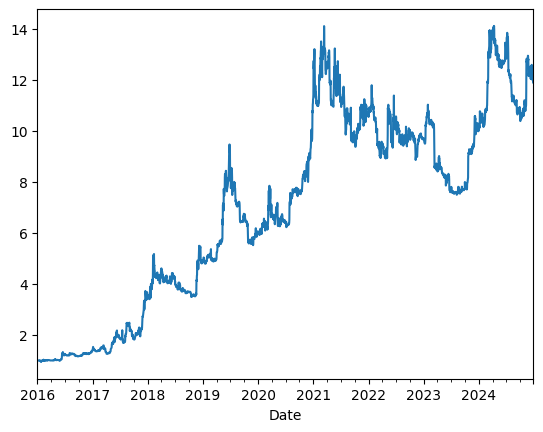

In [9]:
(1+strategy_ma.mean(axis=1)).cumprod().plot()

In [10]:
calculate_metrics(strategy_ma.mean(axis=1))

{'annual_return': np.float64(0.20919441494098012),
 'annual_volatility': np.float64(0.30732637870023133),
 'sharpe_ratio': np.float64(0.7066238754204924)}

In [11]:
strategy_ma.mean(axis=1).mean()

np.float64(0.0009403474687152183)

Port optimization

Min Volatility opotimization

In [12]:
min_vol_portfolio = optimize_min_volatility(strategy_ma)

<Axes: >

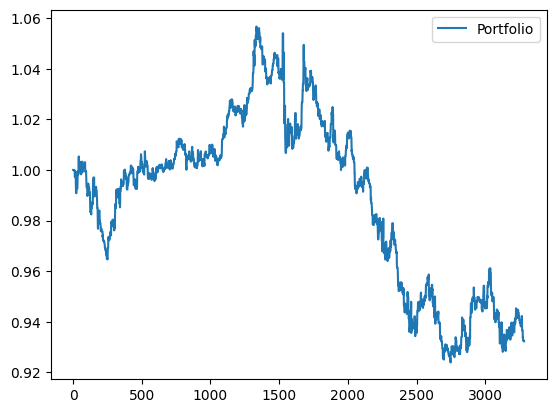

In [13]:
port_opt_min_vol_pct=pd.DataFrame(min_vol_portfolio['Port']).fillna(0)
port_opt_min_vol=(1+port_opt_min_vol_pct).cumprod()
port_opt_min_vol.columns=['Portfolio']
port_opt_min_vol.plot()

In [14]:
port_opt_min_vol_pct.mean()

0   -0.00002
dtype: float64

In [15]:
calculate_metrics(port_opt_min_vol_pct.values)
# Annual return 24% , Sharpe 4

{'annual_return': np.float64(-0.0053684271503465775),
 'annual_volatility': np.float64(0.024667442634653647),
 'sharpe_ratio': np.float64(-1.0086837608927672)}

Max Sharpe Optimization

In [16]:
max_sharpe_portfolio = optimize_max_sharpe(strategy_ma)

In [63]:
weight_df=pd.DataFrame(max_sharpe_portfolio['weights'],index=strategy_ma.columns,columns=['Weight'])
weight_df.sort_values(by='Weight',ascending=False).head(20).round(4)

,Weight
SP500_S16_L17,0.1708
SP500_S6_L15,0.1580
Gold_S4_L5,0.1368
Gold_S19_L21,0.0850
Bond10y_S24_L25,0.0635
Gold_S5_L9,0.0554
Gold_S3_L5,0.0491
Bond10y_S12_L19,0.0468
BTC_S12_L43,0.0411
BTC_S2_L5,0.0392


In [108]:
leverage=3
port_opt_max_sharpe_pct=pd.DataFrame(max_sharpe_portfolio['Port']).fillna(0)
port_opt_max_sharpe_pct.index=strategy_ma.index
port_opt_max_sharpe=(1+port_opt_max_sharpe_pct).cumprod()
weight_select=weight_df[weight_df['Weight']>0.01].index
w=weight_df[weight_df['Weight']>0.01].values
strategy_ma_cumprod = (1+strategy_ma[weight_select] * w.T).cumprod()

port_opt_max_sharpe_leverage=(1+port_opt_max_sharpe_pct*leverage).cumprod()

# Ensure port_opt_max_sharpe has the correct index and column name
port_opt_max_sharpe.columns = ['Portfolio']
port_opt_max_sharpe_leverage.columns = ['Portfolio']

# Create a Plotly figure
fig = go.Figure()

# Add the optimized portfolio to the plot
fig.add_trace(
    go.Scatter(
        x=port_opt_max_sharpe.index,
        y=port_opt_max_sharpe['Portfolio'],
        mode="lines",
        name="Optimized Portfolio",
        line=dict(width=2, color="blue")  # Highlight the portfolio line
    )
)

# fig.add_trace(
#     go.Scatter(
#         x=port_opt_max_sharpe_leverage.index,
#         y=port_opt_max_sharpe_leverage['Portfolio'],
#         mode="lines",
#         name="Optimized Portfolio",
#         line=dict(width=2, color="red")  # Highlight the portfolio line
#     )
# )
# Add cumulative strategy returns with reduced emphasis
for col in strategy_ma_cumprod.columns:
    fig.add_trace(
        go.Scatter(
            x=strategy_ma_cumprod.index,
            y=strategy_ma_cumprod[col],
            mode="lines",
            name=f"Strategy {col}",
            line=dict(width=1),  # Thinner lines
            opacity=0.8  # Transparency for de-emphasis
        )
    )
# Update layout for better visuals
fig.update_layout(
    title="Optimized Portfolio Cumulative Returns",
    xaxis_title="Date",
    yaxis_title="Cumulative Returns",
    legend_title="Legend",
    template="plotly",
    height=600,
    width=1000
)

# Show the figure
fig.show()


In [107]:
calculate_metrics(port_opt_max_sharpe_pct.values)
# Annual return 6% , Sharpe 0.71

{'annual_return': np.float64(0.059445506304817375),
 'annual_volatility': np.float64(0.05487878900645931),
 'sharpe_ratio': np.float64(0.7188670645041593)}

Leverage=5

<Axes: xlabel='Date'>

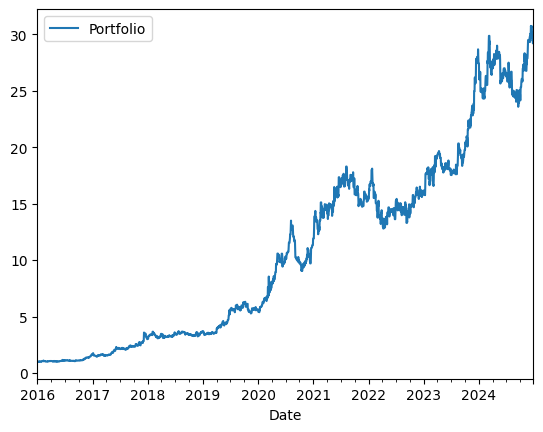

In [117]:
port_opt_max_sharpe_pct=pd.DataFrame(max_sharpe_portfolio['Port']).fillna(0)*5
port_opt_max_sharpe_pct.index=strategy_ma.index
port_opt_max_sharpe=(1+port_opt_max_sharpe_pct).cumprod()
port_opt_max_sharpe.columns=['Portfolio']
port_opt_max_sharpe.plot()

In [118]:
calculate_metrics(port_opt_max_sharpe_pct.values)

{'annual_return': np.float64(0.2955304516639303),
 'annual_volatility': np.float64(0.2743939450322965),
 'sharpe_ratio': np.float64(1.0075528134233025)}

Test BB

In [33]:
# Parameters
windows = list(range(100, 500, 100))
std_devs = np.around(np.arange(0.5, 3.1, 0.5), decimals=2)
tp = 2  # Take profit multiplier
sl = tp  # Stop loss multiplier
leverage = 1
initial_capital = 10000.0

# Initialize lists to collect results
results_list = []
returns = []

for asset in df.columns:
    # Loop over the Bollinger Band window and standard deviation parameters
    for w in windows:
        for s in std_devs:
            # Generate signals
            signals = bollinger_bands_strategy_with_tp_sl(df[asset].dropna(), w, s, tp, sl)
            
            # Calculate return
            r = signals['price'].pct_change(fill_method=None) * signals['signal']
            
            # Backtest the portfolio
            portfolio = backtest_strategy(signals, leverage, initial_capital)
            
            # Calculate cumulative return and Sharpe ratio
            metric_result = calculate_metrics(r)
            
            # Append results to the list
            results_list.append({
                'Asset': asset,
                'Window': w,
                'Std_Dev': s,
                'Annual_Return': metric_result['annual_return'],
                'Sharpe_Ratio': metric_result['sharpe_ratio'],
            })
            
            # Store strategy returns for comparison
            strategy_name = f'{asset}_W{w}_S{s}'
            returns.append(r.rename(strategy_name))

# Convert results to a DataFrame for analysis
results = pd.DataFrame(results_list)
strategy_bb = pd.concat(returns, axis=1)

# Create subplot titles dynamically
subplot_titles = []
for metric in ["Annual Return", "Sharpe Ratio"]:
    for asset in df.columns:
        subplot_titles.append(f"{metric} for {asset}")

# Create subplots: 1 row for returns and 1 row for Sharpe ratios
fig = make_subplots(
    rows=2, cols=4,  # 4 assets in a row
    subplot_titles=subplot_titles,
    shared_yaxes=True,
    vertical_spacing=0.1
)

# Add heatmaps for each asset
for idx, asset in enumerate(results['Asset'].unique()):
    asset_data = results[results['Asset'] == asset]
    
    # Annual Return Heatmap
    pivot_return = asset_data.pivot(index='Window', columns='Std_Dev', values='Annual_Return')
    heatmap_return = go.Heatmap(
        z=pivot_return.values,
        x=pivot_return.columns,
        y=pivot_return.index,
        colorscale="RdBu",
        colorbar=dict(title="Annual Return") if idx == 0 else None,
    )
    fig.add_trace(heatmap_return, row=1, col=idx + 1)

    # Sharpe Ratio Heatmap
    pivot_sharpe = asset_data.pivot(index='Window', columns='Std_Dev', values='Sharpe_Ratio')
    heatmap_sharpe = go.Heatmap(
        z=pivot_sharpe.values,
        x=pivot_sharpe.columns,
        y=pivot_sharpe.index,
        colorscale="RdBu",
        colorbar=dict(title="Sharpe Ratio") if idx == 0 else None,
    )
    fig.add_trace(heatmap_sharpe, row=2, col=idx + 1)

# Update layout
fig.update_layout(
    height=600,  # Smaller height for easier viewing
    width=1200,  # Adjust width accordingly
    title_text="Heatmaps of Annual Return and Sharpe Ratio for Bollinger Band Strategies",
    xaxis_title="Std Dev",
    yaxis_title="Window",
    template="plotly"
)

# Show the figure
fig.show()


BB may not work for these assets

<Axes: xlabel='Date'>

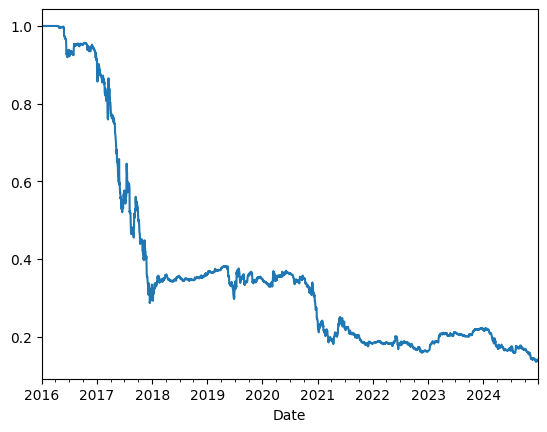

In [34]:
(1+strategy_bb.mean(axis=1)).cumprod().plot()

RSI

In [35]:
# Parameters
windows = list(range(7, 70, 7))  # RSI window sizes
rsi_triggers = range(5, 45, 5)  # RSI trigger levels
tp = 2  # Take profit multiplier
sl = tp  # Stop loss multiplier
leverage = 1
initial_capital = 10000.0

# Initialize lists to collect results
results_list = []
returns = []

for asset in df.columns:
    # Loop over RSI window and RSI trigger levels
    for w in windows:
        for rsi in rsi_triggers:
            # Generate signals
            #print("Asset",asset,w,rsi)
            signals = rsi_strategy_with_tp_sl(data=df[asset], rsi_window=w, overbought=100 - rsi, oversold=rsi, close_on_50=True,tp_pct=0.02, sl_pct=0.02)
            
            # Calculate return
            r = signals['price'].pct_change(fill_method=None) * signals['signal']
            
            # Backtest the portfolio
            portfolio = backtest_strategy(signals, leverage, initial_capital)
            
            # Calculate cumulative return and Sharpe ratio
            metric_result = calculate_metrics(r)
            
            # Append results to the list
            results_list.append({
                'Asset': asset,
                'RSI_Window': w,
                'RSI_Trigger': rsi,
                'Annual_Return': metric_result['annual_return'],
                'Sharpe_Ratio': metric_result['sharpe_ratio'],
            })
            
            # Store strategy returns for comparison
            strategy_name = f'{asset}_rsi_w{w}_rsi{rsi}'
            returns.append(r.rename(strategy_name))

# Convert results to a DataFrame for analysis
results = pd.DataFrame(results_list)
strategy_rsi = pd.concat(returns, axis=1)

# Create subplot titles dynamically
subplot_titles = []
for metric in ["Annual Return", "Sharpe Ratio"]:
    for asset in df.columns:
        subplot_titles.append(f"{metric} for {asset}")

# Create subplots: 1 row for returns and 1 row for Sharpe ratios
fig = make_subplots(
    rows=2, cols=len(df.columns),
    subplot_titles=subplot_titles,
    shared_yaxes=True,
    vertical_spacing=0.1
)

# Add heatmaps for each asset
for idx, asset in enumerate(results['Asset'].unique()):
    asset_data = results[results['Asset'] == asset]

    # Annual Return Heatmap
    pivot_return = asset_data.pivot(index='RSI_Window', columns='RSI_Trigger', values='Annual_Return')
    heatmap_return = go.Heatmap(
        z=pivot_return.values,
        x=pivot_return.columns,
        y=pivot_return.index,
        colorscale="RdBu",
        colorbar=dict(title="Annual Return") if idx == 0 else None,
    )
    fig.add_trace(heatmap_return, row=1, col=idx + 1)

    # Sharpe Ratio Heatmap
    pivot_sharpe = asset_data.pivot(index='RSI_Window', columns='RSI_Trigger', values='Sharpe_Ratio')
    heatmap_sharpe = go.Heatmap(
        z=pivot_sharpe.values,
        x=pivot_sharpe.columns,
        y=pivot_sharpe.index,
        colorscale="RdBu",
        colorbar=dict(title="Sharpe Ratio") if idx == 0 else None,
    )
    fig.add_trace(heatmap_sharpe, row=2, col=idx + 1)

# Update layout
fig.update_layout(
    height=600,
    width=1200,
    title_text="Heatmaps of Annual Return and Sharpe Ratio for RSI Strategies",
    xaxis_title="RSI Trigger Level",
    yaxis_title="RSI Window",
    template="plotly"
)

# Show the figure
fig.show()


C:\Users\Acer\AppData\Local\Temp\ipykernel_141232\690439852.py:585: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Acer\AppData\Local\Temp\ipykernel_141232\690439852.py:585: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Acer\AppData\Local\Temp\ipykernel_141232\690439852.py:585: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Acer\AppData\Local\Temp\ipykernel_141232\690439852.py:585: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Acer\AppData\Local\Temp\ipykernel_141232\690439852.py:585: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Acer\AppData\Local\Temp\ipykernel_141232\690439852.py:585: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Acer\AppData\Local\Temp\ipykernel_141232\690439852.py:585: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Acer\AppData\Local\Temp\ipykernel_141232\690439852.py:585: RuntimeWarning:

divid

Also RSI may not work

We will select ma cross over for port opt. I will try momentum to improve perfromance.

Filter ma param that higher than mean in past x month to be input of port optimzation, and repeat every y month 

In [47]:
lookback_period=252
forward_test_period=30
results_ma_momentum=pd.DataFrame()
weight_limit=0.7
all_asset=pd.DataFrame()
for i in range(0, len(df), forward_test_period):
#for i in range(0, lookback_period*2+1 , lookback_period):
    strategy_ma1=strategy_ma.iloc[i:i+lookback_period]
    
    input_mean=strategy_ma1.mean().mean()
    m=strategy_ma1.mean()
    pos_list=m[m>input_mean].index
    strategy_ma_pos=strategy_ma1[pos_list]
    print("input mean",input_mean)
    print("select input mean",strategy_ma_pos.mean().mean())
    
    forward_ma=strategy_ma[pos_list].iloc[i+lookback_period:i+lookback_period+forward_test_period]
    #print("output",forward_ma.index)
    if len(forward_ma)>0 and strategy_ma_pos.mean().mean()>0:
        results_ma_momentum,asset_weitgh_ma=all_forward(strategy_ma_pos,forward_ma,results_ma_momentum)
        if asset_weitgh_ma is not None:
            print("cummulative return",results_ma_momentum.sum())
            print(asset_weitgh_ma.sort_values(by='Weight',ascending=False))
    
    all_asset=pd.concat([all_asset,asset_weitgh_ma])

input mean 9.424043169854728e-05
select input mean 0.0007328889319706685
cummulative return 0.010890073577787715
               index        Weight       date
589     Gold_S22_L23  2.284195e-01 2016-09-09
649      SP500_S6_L7  1.734822e-01 2016-09-09
706  Bond10y_S22_L25  1.295063e-01 2016-09-09
652     SP500_S6_L13  1.266426e-01 2016-09-09
389     Gold_S10_L15  1.219888e-01 2016-09-09
..               ...           ...        ...
634     SP500_S3_L37  3.802544e-12 2016-09-09
302      Gold_S2_L45  2.082694e-12 2016-09-09
301      Gold_S2_L43  2.071532e-12 2016-09-09
231      BTC_S20_L27  7.685192e-13 2016-09-09
322      Gold_S4_L43  6.584051e-13 2016-09-09

[428 rows x 3 columns]
input mean 0.00011994212687600719
select input mean 0.0007571851159362819
cummulative return 0.02233389523561568
               index        Weight       date
656     Gold_S22_L23  2.106023e-01 2016-10-09
712      SP500_S6_L7  1.831625e-01 2016-10-09
368       Gold_S4_L5  1.204115e-01 2016-10-09
597     Gold_S

In [48]:
all_asset


,index,Weight,date
17,BTC_S2_L47,4.058758e-12,2016-09-09
39,BTC_S4_L5,5.702150e-02,2016-09-09
118,BTC_S12_L13,6.568011e-11,2016-09-09
135,BTC_S13_L21,3.742268e-02,2016-09-09
137,BTC_S13_L25,3.146629e-11,2016-09-09
...,...,...,...
882,Bond10y_S23_L31,3.783922e-12,2024-12-26
883,Bond10y_S23_L33,3.267945e-12,2024-12-26
884,Bond10y_S24_L25,9.977360e-12,2024-12-26
885,Bond10y_S24_L29,4.743278e-12,2024-12-26


<Axes: xlabel='Date'>

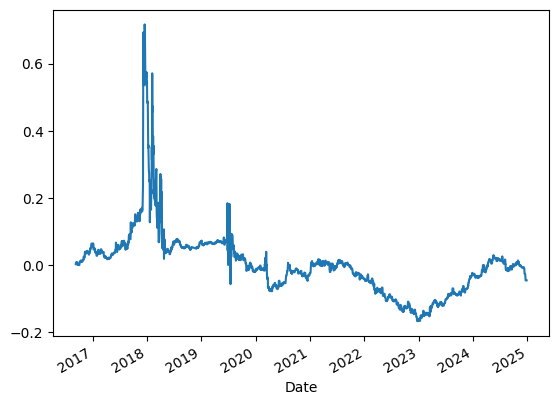

In [50]:
results_ma_momentum.fillna(0).cumsum().plot()